In [37]:
!git clone https://github.com/BenP31/KV6003.git #Download the KV6003 Project files
!git clone https://github.com/tensorflow/models.git #Download and install Object Detection API
%cd '/content/models/research'
!protoc object_detection/protos/*.proto --python_out=.
!cp object_detection/packages/tf2/setup.py .

!python -m pip install -q .

fatal: destination path 'KV6003' already exists and is not an empty directory.
fatal: destination path 'models' already exists and is not an empty directory.
/content/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [38]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras.layers as layers
import tensorflow_datasets as tfds
from object_detection.utils import ops
from object_detection.utils import visualization_utils as viz
from object_detection.utils.label_map_util import create_category_index_from_labelmap
tf.config.run_functions_eagerly(True)


from IPython.display import clear_output

import os
from time import time
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import PIL
import imageio
from random import randint
from KV6003.KV6003 import utils, model, dataset
from KV6003.KV6003.get_mask import predict_mask, get_segmentation_model
import warnings
warnings.simplefilter("ignore")

%matplotlib inline

In [39]:
from google.colab import drive
drive.mount("/content/drive")

%cd "/content/"
!cp "/content/drive/MyDrive/Uni Files/KV6003/model_saves.zip" "/content/models_saves.zip"
!unzip "/content/models_saves.zip"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content
Archive:  /content/models_saves.zip
replace model_saves/image_gan/save-10000-epochs/critic/keras_metadata.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [40]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [58]:
#@title Variables {run:"auto"}
#@markdown File paths
IMAGE_PATH = "/content/obj365_train_000000323551_000.png" #@param{type:"string"}
MASK_RECREATION_GEN_SAVE = "/content/model_saves/mask_gan/save-10000-epochs/generator" #@param {type:"string"}
IMAGE_RECOVERY_GEN_SAVE = "/content/model_saves/image_gan/save-20000-epochs/generator" #@param ["/content/model_saves/image_gan/save-10000-epochs/generator", "/content/model_saves/image_gan/save-20000-epochs/generator"] {style:"string"}


Load and Pre-Process Image

In [79]:
image = tf.keras.utils.img_to_array(tf.keras.utils.load_img(IMAGE_PATH, target_size=(256,256)))
image = tf.cast(image, tf.uint8)

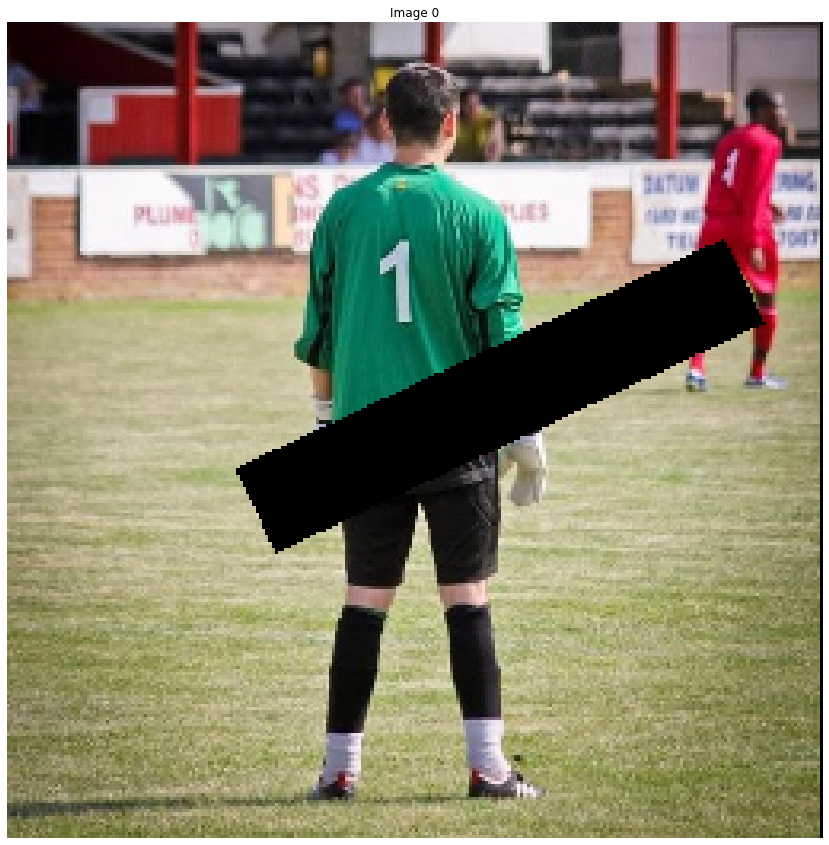

In [80]:
utils.display_images(image)

#Image Segmentation

Load image segmentation model

In [75]:
segmentation = get_segmentation_model()

Predict the segmentation masks (May take a few minutes)

In [76]:
masks = predict_mask(segmentation, tf.expand_dims(image,0))

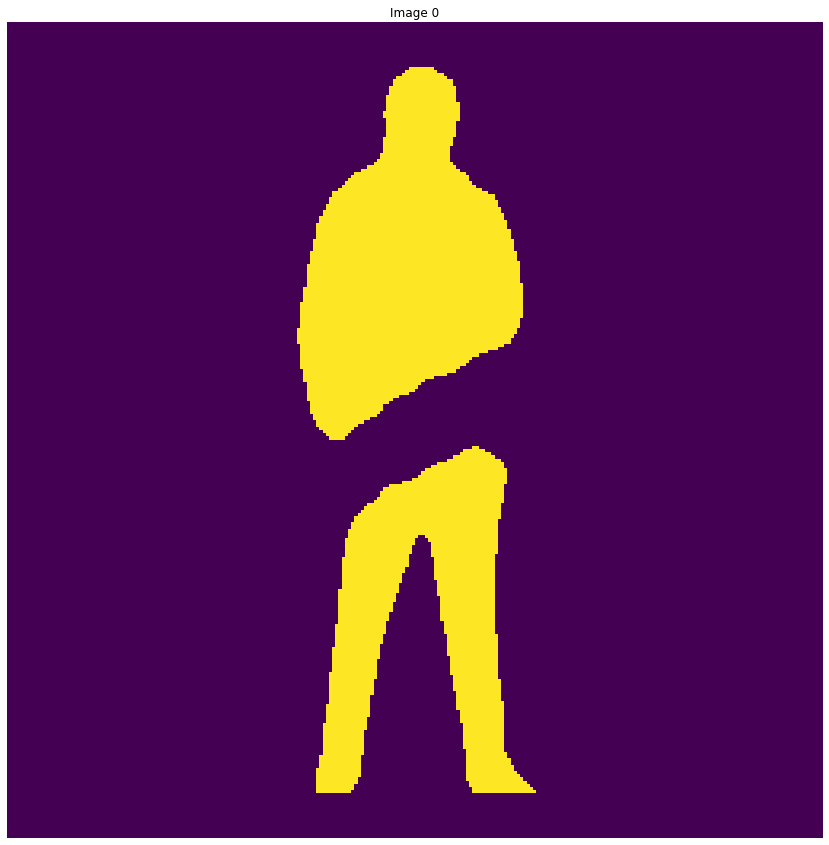

In [77]:
utils.display_images(masks[0])

#Mask Recreation

In [46]:
if 'segmentation' in locals():
    del segmentation
mask_recreation_gen = tf.keras.models.load_model(MASK_RECREATION_GEN_SAVE)

In [47]:
rec_masks = mask_recreation_gen(masks)

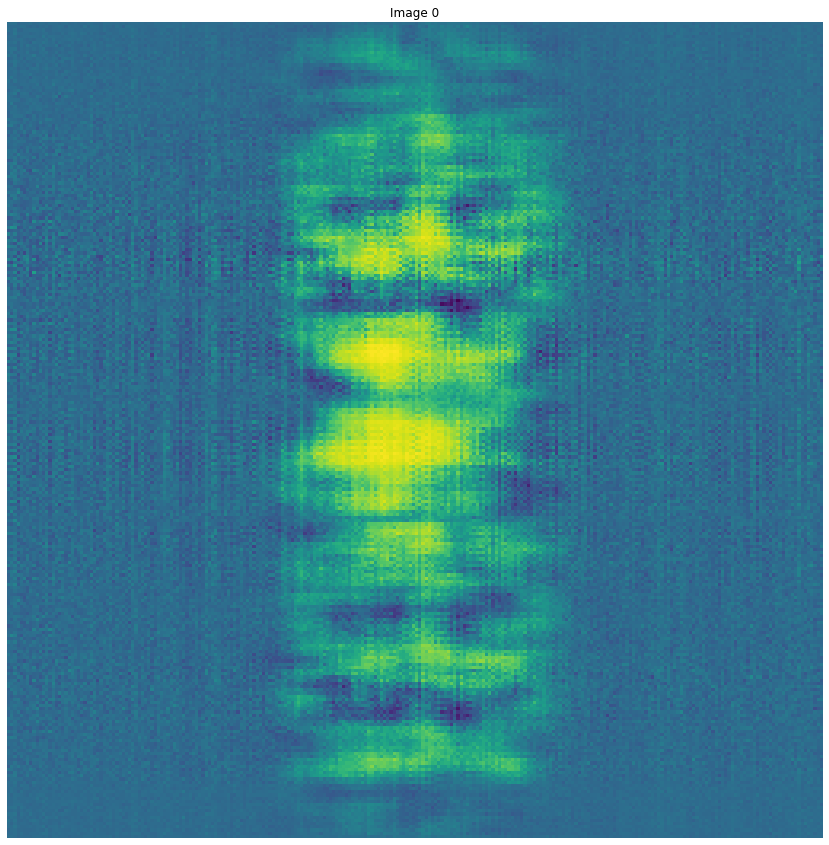

In [48]:
utils.display_images(rec_masks[0])

# Image Recovery

In [59]:
if 'mask_recreation_gen' in locals():
    del mask_recreation_gen
image_recovery_gen = tf.keras.models.load_model(IMAGE_RECOVERY_GEN_SAVE)

Image Inference

In [81]:
fl_image = tf.cast(image, tf.float32)
fl_image = (fl_image/127.5) - 1
rec_images = []
for mask in rec_masks:
    mask = tf.expand_dims(mask, len(tf.shape(mask)))
    zeros = tf.zeros((256,256,2))
    im_mask = tf.concat([fl_image, mask, zeros], axis=2)
    im_mask = tf.expand_dims(im_mask, 0)
    rec_image = image_recovery_gen(im_mask)
    rec_images.append(rec_image)


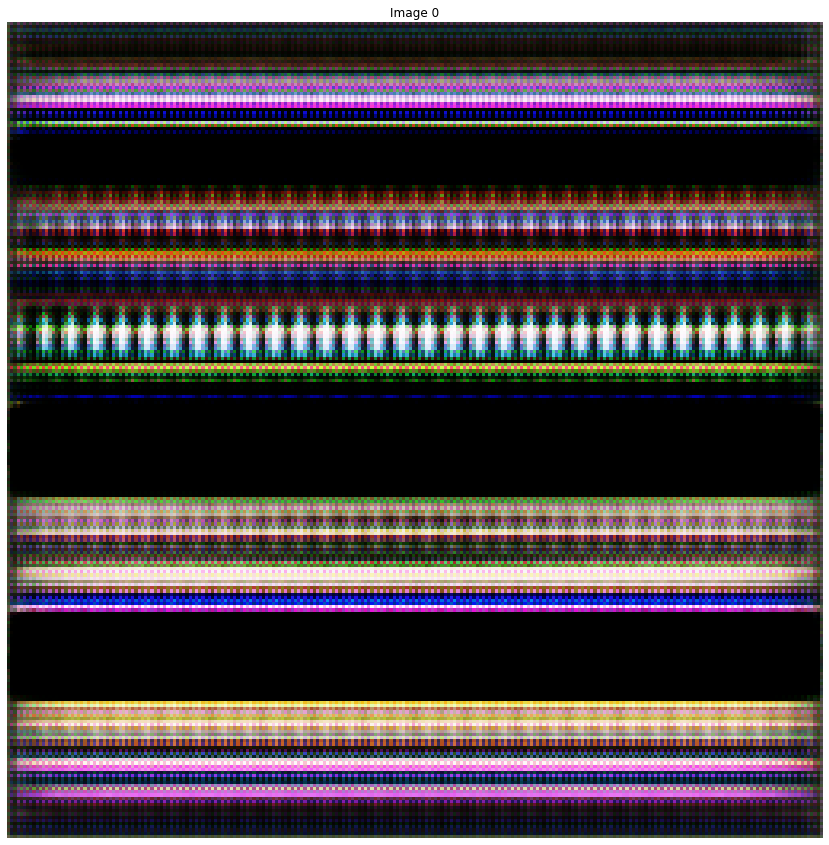

In [82]:
utils.display_images(rec_images[0]*0.5 + 0.5)

Putting it all together

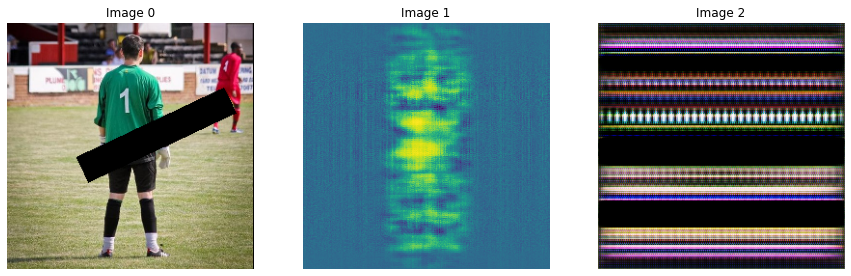

In [84]:
utils.display_images(image, rec_masks[0], rec_image*0.5+0.5)